# Pre-processing

## Importación de bibliotecas

In [87]:
import time
start_time = time.time()
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests
import random
import dataframe_image as dfi

## Importación de dataset

In [88]:
nocols = ['Unnamed: 0', 'Unnamed: 0.1']

raw_df = pd.read_csv("./data/cabaventa.csv").drop(columns = nocols)
raw_df.shape

(183810, 25)

## Características del dataset

Se definen funciones accesorias para el recupero de las características del dataset

In [89]:
def rango(col): 
    col = col.dropna()
    if len(col)==0:
        return ""
    if np.issubdtype(col.dtype, np.number):
        return "["+"{:.2f}".format(col.min())+","+"{:.2f}".format(col.max())+"]"
    else: 
        return ""

def ejemplo(col, col_width=30):
    uniques = col.dropna().unique()
    if len(uniques) == 0: 
        return ""
    if len(uniques)<4: 
        s = ",".join([str(x) for x in uniques])
        if len(s)>col_width:
            return s[:col_width]+"..."
        else:
            return s
    else:
        vcounts = col.value_counts().index
        s = ", ".join([str(x) for x in vcounts[:3]])+"..."
        if len(s)>col_width:
            return s[:col_width]+"..."
        else:
            return s
    

def get_dataframe_info(df):
    
    dtypes = df.dtypes    
    nulls = (df.isna().sum()/len(df)).apply(lambda x: "{:.2%}".format(x))
    nuniques = df.nunique()
    ejemplos = df.apply(lambda col: ejemplo(col), axis=0)
    rangos = df.apply(lambda col: rango(col), axis=0)
    info_df = pd.concat([dtypes, nulls, nuniques, ejemplos, rangos], axis=1)
    info_df.columns = ['TipoDato',"PorcentajeNulos","ValoresUnicos","Ejemplos", "Rangos"]
    return info_df

tabla = get_dataframe_info(raw_df)
#tabla.to_latex()
dfi.export(tabla, "img/tabla1.png")
tabla

,TipoDato,PorcentajeNulos,ValoresUnicos,Ejemplos,Rangos
id,object,0.00%,183810,"hjHZd/BZqSBy3zb+RrqPYg==, 6SeS...",
ad_type,object,0.00%,1,Propiedad,
start_date,object,0.00%,362,"2020-10-02, 2020-12-03, 2020-0...",
end_date,object,0.00%,449,"9999-12-31, 2021-06-05, 2021-0...",
created_on,object,0.00%,362,"2020-10-02, 2020-12-03, 2020-0...",
lat,float64,6.23%,69507,"-34.612754, -34.5589436, -34.5...","[-53.79,29.75]"
lon,float64,6.23%,70182,"-58.4132648, -58.475767, -58.4...","[-100.47,-5.49]"
l1,object,0.00%,1,Argentina,
l2,object,0.00%,1,Capital Federal,
l3,object,1.00%,57,"Palermo, Belgrano, Caballito.....",


## Limpieza Texto y Columnas

### Limpieza inicial

Se eliminan los registros con currency = ARS y se dropea esa columna por carecer de valor predictivo

In [90]:
raw_df = raw_df[raw_df['currency']== "USD"]
raw_df.drop(columns='currency', axis=1, inplace=True) 

El dataset posee 8 registros de tipo de propiedad "Casa de campo". Se considera que con un número tan bajo de registros no será posible realizar predicciones de calidad para ese tipo de propiedad, por lo que se eliminan los registros del dataset.

In [91]:
raw_df = raw_df[raw_df['property_type']!= "Casa de campo"]

### Normalización de campos

En esta parte se realiza una limpieza básica con `regex` de algunas columnas a los fines de normalizar un poco el texto: lowering, punctuation, spaces, digits. La función armada permite customizar la limpieza, por ende es posible no aplicar la misma limpieza para todos los casos. La función genera columnas nuevas con el nombre`f"{col}_cleaned"`  

Dado que las columnas textuales `title` y `description` no fueron utilizadas en la predicción ni analizadas mediante técnicas de embeddings o BOW, no se trataron los NaN en esas columnas. 

In [92]:
from cleaning import CleaningData
#instanciamos Cleaning Data con df

cleaned = CleaningData(data=raw_df)

In [93]:
#Quitamos columnas 
cols_to_drop = [#'Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', #todas las filas iguales 
                'l2', #todas las filas iguales 
                'ad_type', #todas las filas iguales 
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
                'price_period' #la columna contiene muchos NaN y un único valor
               ]
data = cleaned.drop_columns(columns=cols_to_drop)
data.shape

Cleaning columns with no valuable information...



(179798, 16)

In [94]:
#Limpieza title
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="title", params=params)
data.shape

(179798, 17)

In [95]:
#Limpieza description
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="description", params=params)
data.shape

(179798, 18)

In [96]:
#Limpieza texto de l3
params = {'lowering':False,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="l3", params=params)
data.shape

(179798, 19)

### Mejoras en la delimitación e imputación de barrios

#### Valores nulos

In [97]:
(data[['lat','lon','l3_cleaned']].isna().sum()/len(data)).apply(lambda x: "{:.2%}".format(x))

lat           6.15%
lon           6.15%
l3_cleaned    0.90%
dtype: object

Se detectó una mayor presencia de valores nulos en los datos de georreferenciación que en el dato del barrio. Por ende se realizó un trabajo de imputación de nulos partiendo de considerar a la columna `l3_cleaned` con una mayor validez que la columnas `lat` y `lon`. Por ende, fue tomada como "eje" para realizar imputación de nulos. 

#### Errores

* Se analizaron los barrios cuya denomiación no es la denominación oficial: Ejemplo Centro / Microcentro, Las Cañitas, Pompeya, Abasto, Once, etc. 

In [98]:
data.l3_cleaned.dropna().unique()

array(['Floresta', 'Belgrano', 'Recoleta', 'Monserrat', 'San Nicolas',
       'Retiro', 'Almagro', 'Palermo', 'Saavedra', 'Chacarita',
       'Barrio Norte', 'Villa Crespo', 'Villa Pueyrredon', 'Flores',
       'Villa Urquiza', 'Once', 'Coghlan', 'Congreso', 'Villa Devoto',
       'Boedo', 'Nunez', 'Barracas', 'Colegiales', 'Villa del Parque',
       'Caballito', 'Balvanera', 'San Telmo', 'Monte Castro',
       'Villa General Mitre', 'Parque Chacabuco', 'Abasto',
       'Puerto Madero', 'Parque Chas', 'San Cristobal',
       'Villa Santa Rita', 'Villa Lugano', 'Liniers', 'Agronomia',
       'Villa Ortuzar', 'Villa Soldati', 'Villa Luro',
       'Parque Centenario', 'Las Canitas', 'Paternal',
       'Centro Microcentro', 'Mataderos', 'Parque Avellaneda', 'Pompeya',
       'Parque Patricios', 'Tribunales', 'Boca', 'Villa Real',
       'Constitucion', 'Versalles', 'Catalinas', 'Velez Sarsfield',
       'Villa Riachuelo'], dtype=object)

* Se analizaron registros para los que la variable `lat` presentó valores fuera del polígono de CABA

In [99]:
data.lat.describe()

count    168742.000000
mean        -34.590229
std           0.368811
min         -53.788624
25%         -34.615766
50%         -34.596917
75%         -34.577251
max          29.753374
Name: lat, dtype: float64

* Se analizaron registros para los que la variable `lon` presentó valores fuera del polígono de CABA

In [100]:
data.lon.describe()

count    168742.000000
mean        -58.459761
std           0.491655
min        -100.469651
25%         -58.464889
50%         -58.439285
75%         -58.408229
max          -5.490771
Name: lon, dtype: float64

#### Procesamiento realizado

Se establecieron los siguientes pasos: 

1. A los registros cuya localización no correspondía a CABA se les imputó NaN, para ello se utilizó geoJson del polígono de CABA

Fueron 11722 los casos en que la localización era externa a CABA


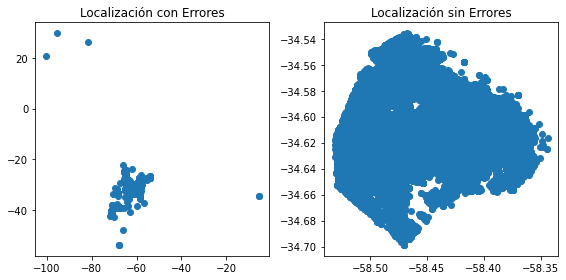

In [101]:
import json
path = "./metadata/provincia.json"
with open(path, "r", encoding="utf-8") as js: 
    js = json.load(js)


poligono_caba = [tuple(x) for x in js['features'][0]['geometry']['coordinates'][0][0]]

from geoBarrios import point_in_polygon

def is_caba(coord): 
    return(point_in_polygon(coord, poligono_caba))

data['is_caba'] = [is_caba((lon, lat)) for lon, lat in zip(data.lon, data.lat)]

print(f"Fueron {(data.is_caba==False).sum()} los casos en que la localización era externa a CABA")

data.loc[~data.is_caba, ['lon','lat']] = np.nan

fig, axs = plt.subplots(ncols=2, figsize=(8,4))

lon , lat = raw_df.lon , raw_df.lat #guardo la localización como vino del dataset
axs[0].scatter(lon,lat)
axs[0].set_title("Localización con Errores")

axs[1].scatter(data.lon,data.lat)
plt.title("Localización sin Errores")
plt.tight_layout()
plt.show()

2. 1: Normalización datos de barrios porteños: dado que eran pocos casos en los que el inmueble pertenecía a un barrio no oficial de CABA según la columna `l3_cleaned` se realizó una imputación manual. Ej: Las Canitas ---> Palermo. Pompeya --> Nueva Pompeya. Abasto --> Almagro. En un trabajo posterior debería ser revisado y refinado ya que hay casos como Once, Parque Centenario, que son zonas pertenecientes a una mezcla de barrios. 

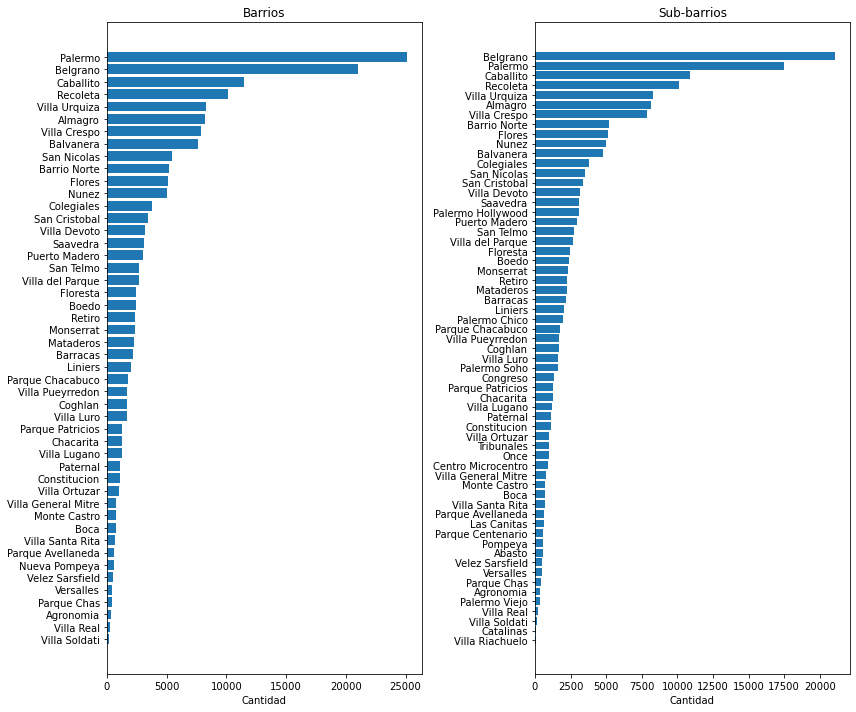

In [102]:
normalizador = {
    'Pompeya': 'Nueva Pompeya',
    'Las Canitas': 'Palermo',
    'Parque Centenario': 'Caballito', #Puede haber propiedades que en realidad pertenezcan a Almagro o Caballito
    'Centro Microcentro':'San Nicolas',
    'Tribunales':'San Nicolas',
    'Once':'Balvanera',  #puede haber propiedades que en realidd pertenezcan a Almagro.
    'Abasto':"Balvanera",  #puede haber propiedades que en realidad pertenezcan a Almagro. 
    "Catalinas":"Retiro", # la mayor parte de los casos caen ahí (algunos en Boca) 
    'Congreso':"Balvanera", #La mayor parte de los casos caen ahí (algunos en Belgrano)
    "Villa Riachuelo":"Villa Lugano", #Al ser pocas propiedades se imputó el barrio más próximo.
}

data['l3_norm'] = data.l3_cleaned.apply(lambda x: normalizador[x] if x in normalizador else x)
data['l4_nuevo'] = np.where(data.l4.isna()==False, data.l4, 
                            np.where(data.l3_cleaned != data.l3_norm, data.l3_cleaned, data.l3_norm)
                           )


gr1 = data.groupby("l3_norm")['id'].count().sort_values(ascending=False)

gr2 = data.groupby("l4_nuevo")['id'].count().sort_values(ascending=False)

fig, axs = plt.subplots(figsize = (12,10) , ncols=2)


barrios = gr1.index
cantidad1 = gr1.values

sub_barrios = gr2.index
cantidad2 = gr2.values

axs[0].barh(barrios, cantidad1, align='center')
axs[0].invert_yaxis()  # labels read top-to-bottom
axs[0].set_xlabel('Cantidad')
axs[0].set_title('Barrios')

axs[1].barh(sub_barrios, cantidad2, align='center')
axs[1].invert_yaxis()  # labels read top-to-bottom
axs[1].set_xlabel('Cantidad')
axs[1].set_title('Sub-barrios')

plt.tight_layout()
plt.show()

2. 2: Si para un registro el par de columnas `lat`, `lon` presentaron valores NaN, se imputó el valor para cada columna con el promedio de las coordenadas del barrio. Si para dicho registro el dato del barrio fue nulo entonces se quitó toda la fila.

In [103]:
no_location = (data['lat'].isna()) & data['lon'].isna() & (data['l3_norm'].isna())
print(f"Fueron {no_location.sum()} los casos en que no habia locación")
data = data[~no_location].reset_index(drop=True)

Fueron 1556 los casos en que no habia locación


Para aquellas propiedades que sí tenían barrio, pero no las coordenadas geográficas, se imputó para cada columna con el promedio barrial de las coordenadas geográficas presentes en el dataset.

In [104]:
lat_lon_barrios = data.groupby('l4_nuevo')[['lat', 'lon']].mean().reset_index()
lat_lon_barrios.columns = ['l4_nuevo','lat_barrio', 'lon_barrio']

data = pd.merge(data, lat_lon_barrios, how="left", left_on='l4_nuevo', right_on = 'l4_nuevo')

data['lat'] = np.where(data['lat'].isna(), data['lat_barrio'], data['lat'])
data['lon'] = np.where(data['lon'].isna(), data['lon_barrio'], data['lon'])

3. Luego de este procesamiento si el barrio del registro presentaba un valor NaN se imputó el barrio correspondiente a la coordenada.

In [105]:
from geoBarrios import geoBarrios, coord_to_nbhd
barrios_dict = geoBarrios()
print(f"Un total de {data.l4_nuevo.isna().sum()} casos poseían barrio nulo y se les imputo el barrio correspondiente a la coordenada") 
data.loc[data.l4_nuevo.isna(), "l4_nuevo"] = data[data.l4_nuevo.isna()].apply(lambda row: coord_to_nbhd(coord=(row.lon,row.lat),polygons_dict=barrios_dict), axis=1).values
data.loc[data.l3_norm.isna(), "l3_norm"] = data[data.l3_norm.isna()].apply(lambda row: coord_to_nbhd(coord=(row.lon,row.lat),polygons_dict=barrios_dict), axis=1).values

Un total de 64 casos poseían barrio nulo y se les imputo el barrio correspondiente a la coordenada


In [106]:
data.drop(columns = ["l3","l3_cleaned","l4","is_caba","lat_barrio","lon_barrio"], inplace=True)

In [107]:
data.isna().sum()

id                         0
start_date                 0
end_date                   0
lat                        0
lon                        0
rooms                  25827
bedrooms               47360
bathrooms              23343
surface_total          59716
surface_covered        61057
price                      0
title                      0
description                0
property_type              0
title_cleaned              0
description_cleaned        0
l3_norm                    0
l4_nuevo                   0
dtype: int64

**Pendiente para un próximo abordaje**

* Para los casos en que la localización era externa a CABA y el barrio no nulo, se imputó un punto centroide del barrio. Eso pudo conducir a errores dado que implícitamente se "confía" en que el dato del barrio fue correcto. Una alternativa sería probar adicionalmente si de la columna `description_cleaned` fuera posible confirmar que no se tratase de casos que efectivamente pertenecieran a localizaciones externas a CABA. 
* Si el barrio y la localización no son nulos pero sí incongruentes (localización pertence a otro barrio) se procedío a imputar el punto centroide del barrio. . 

In [108]:
data.shape

(178242, 18)

## Trabajo sobre las variables: superficie total, superficie cubierta, ambientes, dormitorios y precio

#### Exploración de variables

In [109]:
cols = ["surface_total","surface_covered","rooms","bedrooms", "price"]
(data[cols].isna().sum()/len(data)).apply(lambda x: "{:.2%}".format(x))

surface_total      33.50%
surface_covered    34.26%
rooms              14.49%
bedrooms           26.57%
price               0.00%
dtype: object

Se exploraron los valores no nulos las columnas `rooms` y `bedrooms`, según el tipo de propiedad. 

In [110]:
100*(data[['rooms','bedrooms']].isnull()==False).groupby(data['property_type']).sum().div(data.groupby("property_type")['rooms','bedrooms'].apply(lambda gr: len(gr)), axis=0) 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12140\3685459722.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  100*(data[['rooms','bedrooms']].isnull()==False).groupby(data['property_type']).sum().div(data.groupby("property_type")['rooms','bedrooms'].apply(lambda gr: len(gr)), axis=0)


,rooms,bedrooms
property_type,,
Casa,80.155155,75.588088
Cochera,46.247068,18.588741
Departamento,95.359380,82.514057
Depósito,20.431655,13.381295
Local comercial,29.952153,10.303030
Lote,18.708988,10.788952
Oficina,40.420978,20.192651
Otro,35.179641,32.035928
PH,93.129657,93.748137


Revisión de casos en los que `surface_total` fuera menor a `surface_covered`

In [111]:
data.surface_total.describe()

count    118526.000000
mean        151.778336
std        1139.253429
min          10.000000
25%          45.000000
50%          70.000000
75%         123.000000
max      140380.000000
Name: surface_total, dtype: float64

In [112]:
(data.surface_total < data.surface_covered).sum() 

872

* outliers en `surface_covered`

In [113]:
data.surface_covered.describe()

count    117185.000000
mean        133.686999
std        1352.340800
min           1.000000
25%          40.000000
50%          60.000000
75%         100.000000
max      170000.000000
Name: surface_covered, dtype: float64

* `rooms < bedrooms`

In [114]:
(data.rooms < data.bedrooms).sum() 

544

* outliers en `rooms`

In [115]:
data.rooms.describe()

count    152415.000000
mean          2.700279
std           1.510932
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          40.000000
Name: rooms, dtype: float64

* outliers en `bedrooms`

In [116]:
data.bedrooms.describe()

count    130882.000000
mean          1.959406
std           1.830851
min          -2.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         153.000000
Name: bedrooms, dtype: float64

#### Conclusiones preliminares

* Las columnas `rooms` y `bedrooms` poseen muchos nulos siempre que los avisos se traten de cocheras, depósitos, locales comerciales, lotes, oficinas, otros. Para las propiedades utilizadas como vivienda en cambio la presencia de nulos es mucho menor. 
* Dada la alta correlación entre `surface_total` y `surface_covered` y entre `rooms` y `bedrooms`, para los casos en que el par tuviera datos nulos se procederá  a eliminar la fila ante la dificultad para imputar nulos en esos casos. 
* Para la variable `price` se eliminarán las filas que tenían nulos ya que por ser la variable sobre la cual se constuirá la variable respuesta se decidió no realizar imputación de valores faltantes sobre la misma. 

#### Procesamiento realizado

1. Reemplazar rooms y bedrooms 0 para property_type 'Local comercial', 'Depósito', 'Cochera', 'Lote', 'Oficina', 'Otro'

In [117]:
data.loc[data.property_type.isin(["Cochera","Depósito","Local comercial","Lote","Oficina","Otro"]),["rooms","bedrooms"]] = data.loc[data.property_type.isin(["Cochera","Depósito","Local comercial","Lote","Oficina","Otro"]),["rooms","bedrooms"]].fillna(0)

In [118]:
data.shape

(178242, 18)

In [119]:
nas_rb = data[data[['rooms', 'bedrooms']].isna().any(axis=1)][['rooms', 'bedrooms', 'l3_norm']].groupby('l3_norm').count()

2. Eliminar registros para los que el par `rooms` - `bedrooms` fuera Nan

In [120]:
#punto 1
data.dropna(subset = ['rooms', 'bedrooms'], how = 'all', inplace = True)
data.shape


(174212, 18)

3. Eliminar registros para los que el par `surface_total` - `surface_covered` fuera Nan

In [121]:
data.dropna(subset = ['surface_total', 'surface_covered'], how = 'all', inplace=True)
data.shape

(121980, 18)

4. Eliminar registros con `price` Nan

In [122]:
data.dropna(subset =['price'], inplace=True)
data.shape

(121980, 18)

In [123]:
data.isnull().sum()

id                         0
start_date                 0
end_date                   0
lat                        0
lon                        0
rooms                   1930
bedrooms               17208
bathrooms              10451
surface_total           5365
surface_covered         6706
price                      0
title                      0
description                0
property_type              0
title_cleaned              0
description_cleaned        0
l3_norm                    0
l4_nuevo                   0
dtype: int64

In [124]:
data[['rooms','bedrooms']].isnull().groupby(data['property_type']).sum()

,rooms,bedrooms
property_type,,
Casa,1086,1475
Cochera,0,0
Departamento,665,15522
Depósito,0,0
Local comercial,0,0
Lote,0,0
Oficina,0,0
Otro,0,0
PH,179,211


5. Invertir valores para los registros cuya `surface_total` fuera menor a `surface_covered`, y cuyo valor en `bedrooms` fuera menor al de `rooms`

In [125]:
#punto 2
idx = data[data.surface_total<data.surface_covered].index
data.loc[idx,['surface_total','surface_covered']] = data.loc[idx,['surface_covered','surface_total']].values

idx = data[data.rooms<data.bedrooms].index
data.loc[idx,['rooms','bedrooms']] = data.loc[idx,['bedrooms','rooms']].values

6. Si para un registro uno de los valores de ['surface_total', 'surface_covered'] contiene valor outlier y el otro no es outlier, se le imputó un NaN al dato outlier y se dejó dicho valor para ser imputado luego si correspondiera. Si ambos valores son outliers, se eliminó la fila.

In [126]:
#Generamos quantiles .01 y .99 para surface_total
data_st = data[['l3_norm', 'property_type', 'surface_total', 'rooms']]
data_st_q99 = data_st.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_st_q99.rename(columns = {'surface_total':'p99_surface_total'}, inplace = True)

data_sc = data[['l3_norm', 'property_type', 'surface_covered', 'rooms']]
data_sc_q99 = data_sc.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_sc_q99.rename(columns = {'surface_covered':'p99_surface_covered'}, inplace = True)

In [127]:
data = data.merge(data_st_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_sc_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))

In [128]:
##Generamos quantiles .01 y .99 para surface_covered
data_st_q01 = data_st.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_st_q01.rename(columns = {'surface_total':'p01_surface_total'}, inplace = True)

data_sc_q01 = data_sc.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_sc_q01.rename(columns = {'surface_covered':'p01_surface_covered'}, inplace = True)

In [129]:
data = data.merge(data_st_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_sc_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))

In [130]:
# Registros con un outlier en surface_total
data[(data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total'])]

,id,start_date,end_date,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,description,property_type,title_cleaned,description_cleaned,l3_norm,l4_nuevo,p99_surface_total,p99_surface_covered,p01_surface_total,p01_surface_covered
102,PemU7aTq7eOemVs2VhELog==,2021-03-21,2021-08-08,-34.583765,-58.438449,4.0,2.0,1.0,59.0,51.0,...,Corredor Responsable: MAURO MARVISI - CPI 1762...,Departamento,venta dpto tres ambientes palermo hollywood,corredor responsable mauro marvisi cpi 1762 cs...,Palermo,Palermo,390.00,320.00,65.00,61.00
162,9a8rX1nJeJQvLQnThubSgA==,2021-03-21,2021-03-23,-34.604538,-58.424956,1.0,NaN,1.0,93.0,55.0,...,Departamento monoambiente al frente.,Departamento,departamento almagro norte,departamento monoambiente al frente,Almagro,Almagro,70.00,52.92,18.00,18.00
301,uwMVSyXStSbBGCECdHTLRg==,2021-03-21,2021-06-05,-34.634389,-58.439524,7.0,3.0,5.0,251.0,188.0,...,EXTRAORDINARIO DUPLEX EN ALTURA FRENTE AL PARQ...,Departamento,departamento parque chacabuco,extraordinario duplex en altura frente al parq...,Parque Chacabuco,Parque Chacabuco,249.52,187.18,170.14,147.00
318,zUCi4fvmZB/BC32qhmdDag==,2020-06-09,2020-06-17,-34.578064,-58.426533,3.0,0.0,2.0,300.0,300.0,...,INMOBILIARIA VENDE FONDO DE COMERCIO SALON DE ...,Local comercial,victor hugo 1100 100 u d 20000 fondo de comerc...,inmobiliaria vende fondo de comercio salon de ...,Villa Luro,Villa Luro,298.40,298.10,141.60,111.90
330,xD39tzWmELkh4+9xepoh/g==,2020-06-09,2021-04-09,-34.632771,-58.461178,3.0,NaN,3.0,270.0,250.0,...,Excelente piso de 4 ambientes 250 m2 cubiertos...,Departamento,rivera indarte 300 5 u d 590000 departamento e...,excelente piso de 4 ambientes 250 m2 cubiertos...,Caballito,Caballito,181.64,140.04,44.00,43.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121936,qvQt6l7JzZCIt62s6UseYQ==,2020-12-04,2021-01-02,-34.610644,-58.387501,4.0,3.0,2.0,256.0,108.0,...,Corredor Responsable: Maria Badino - CUCICBA ...,Departamento,departamento 3 amb 3 e pisos y terraza 256 m2,corredor responsable maria badino cucicba 7586...,Balvanera,Congreso,210.83,190.00,56.00,52.32
121942,BHYBAC9cJaTbCILCLCusuA==,2020-12-04,2021-02-17,-34.591076,-58.398509,4.0,3.0,1.0,61.0,55.0,...,<br><br>Corredor interviniente CABA y PBA : Ju...,Departamento,departamento recoleta,br br corredor interviniente caba y pba juan p...,Recoleta,Recoleta,345.30,299.30,70.00,64.00
121957,kEVQxU5Mw3p5L8BVuRdP6Q==,2020-12-04,9999-12-31,-34.587736,-58.417551,5.0,3.0,2.0,568.0,452.0,...,Casona señorial declarada Patrimonio Histórico...,Local comercial,casa palermo,casona senorial declarada patrimonio historico...,Palermo,Palermo,559.90,449.40,170.00,151.00
121958,Adcee8H5XBFNsAXmRe4Psg==,2020-12-04,2020-12-09,-34.641483,-58.420296,5.0,4.0,2.0,106.0,90.0,...,Corredor Responsable: Martin Macagno - CUCICBA...,PH,ph venta pompeya 5amb con patio y terraza,corredor responsable martin macagno cucicba 62...,Nueva Pompeya,Pompeya,290.92,170.00,106.24,82.64


In [131]:
# Registros con un outlier en surface_covered
data[(data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered'])]

,id,start_date,end_date,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,description,property_type,title_cleaned,description_cleaned,l3_norm,l4_nuevo,p99_surface_total,p99_surface_covered,p01_surface_total,p01_surface_covered
3,+KGGxikZuWylLGEfAS1QQQ==,2020-08-22,2020-09-04,-34.603233,-58.385218,1.0,0.0,1.0,NaN,12.0,...,VENTA DE OFICINA A METROS DEL PALACIO DE TRIBU...,Oficina,oficina san nicolas,venta de oficina a metros del palacio de tribu...,San Nicolas,San Nicolas,240.64,462.68,17.00,16.00
102,PemU7aTq7eOemVs2VhELog==,2021-03-21,2021-08-08,-34.583765,-58.438449,4.0,2.0,1.0,59.0,51.0,...,Corredor Responsable: MAURO MARVISI - CPI 1762...,Departamento,venta dpto tres ambientes palermo hollywood,corredor responsable mauro marvisi cpi 1762 cs...,Palermo,Palermo,390.00,320.00,65.00,61.00
162,9a8rX1nJeJQvLQnThubSgA==,2021-03-21,2021-03-23,-34.604538,-58.424956,1.0,NaN,1.0,93.0,55.0,...,Departamento monoambiente al frente.,Departamento,departamento almagro norte,departamento monoambiente al frente,Almagro,Almagro,70.00,52.92,18.00,18.00
249,asQZI0Zh5PP0G5cd/dBLLg==,2021-03-21,2021-06-05,-34.609406,-58.362788,2.0,1.0,1.0,NaN,34.0,...,"Las mejores vistas de Puerto Madero, el barrio...",Departamento,venta departamento puerto madero,las mejores vistas de puerto madero el barrio ...,Puerto Madero,Puerto Madero,154.26,153.00,47.00,42.00
301,uwMVSyXStSbBGCECdHTLRg==,2021-03-21,2021-06-05,-34.634389,-58.439524,7.0,3.0,5.0,251.0,188.0,...,EXTRAORDINARIO DUPLEX EN ALTURA FRENTE AL PARQ...,Departamento,departamento parque chacabuco,extraordinario duplex en altura frente al parq...,Parque Chacabuco,Parque Chacabuco,249.52,187.18,170.14,147.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121910,4MUVmvijBYcyNmJ9XPNJfw==,2020-12-04,2020-12-30,-34.594509,-58.413244,4.0,3.0,1.0,63.0,52.0,...,Luminoso departamento de tres ambientes al fre...,Oficina,4 ambientes billinghurst al 1300 recoleta,luminoso departamento de tres ambientes al fre...,Recoleta,Recoleta,133.58,123.55,58.70,52.90
121911,YK2Ith6/v1ejgsxOeBy5Yg==,2020-12-04,2020-12-30,-34.594509,-58.413244,4.0,3.0,1.0,63.0,52.0,...,Luminoso departamento de tres ambientes al fre...,Oficina,4 ambientes billinghurst al 1300 recoleta,luminoso departamento de tres ambientes al fre...,Barrio Norte,Barrio Norte,148.00,138.20,63.30,52.48
121942,BHYBAC9cJaTbCILCLCusuA==,2020-12-04,2021-02-17,-34.591076,-58.398509,4.0,3.0,1.0,61.0,55.0,...,<br><br>Corredor interviniente CABA y PBA : Ju...,Departamento,departamento recoleta,br br corredor interviniente caba y pba juan p...,Recoleta,Recoleta,345.30,299.30,70.00,64.00
121957,kEVQxU5Mw3p5L8BVuRdP6Q==,2020-12-04,9999-12-31,-34.587736,-58.417551,5.0,3.0,2.0,568.0,452.0,...,Casona señorial declarada Patrimonio Histórico...,Local comercial,casa palermo,casona senorial declarada patrimonio historico...,Palermo,Palermo,559.90,449.40,170.00,151.00


In [132]:
#Eliminación de registros con 2 precios outliers
data = data[(data['surface_total'] < data['p99_surface_total']) & (data['surface_total'] > data['p01_surface_total']) & (data['surface_covered'] < data['p99_surface_covered']) & (data['surface_covered'] > data['p01_surface_covered'])]

In [133]:
# Registros con un outlier en surface_covered
data[(data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered'])]

,id,start_date,end_date,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,description,property_type,title_cleaned,description_cleaned,l3_norm,l4_nuevo,p99_surface_total,p99_surface_covered,p01_surface_total,p01_surface_covered


In [134]:
# Registros con un outlier en surface_total
data[(data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total'])]

,id,start_date,end_date,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,description,property_type,title_cleaned,description_cleaned,l3_norm,l4_nuevo,p99_surface_total,p99_surface_covered,p01_surface_total,p01_surface_covered


In [135]:
#Paso a NA el registro outlier de surface_total o surface_covered
data['surface_total'] = np.where((data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total']), np.nan, data['surface_total'])
data['surface_covered'] = np.where((data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered']), np.nan, data['surface_covered'])
#Dropeo columnas accesorias
data = data.drop(columns= ['p99_surface_total', 'p01_surface_total', 'p99_surface_covered', 'p01_surface_covered'], axis = 1)

In [136]:
data.isnull().sum()

id                         0
start_date                 0
end_date                   0
lat                        0
lon                        0
rooms                      0
bedrooms               14665
bathrooms               4959
surface_total              0
surface_covered            0
price                      0
title                      0
description                0
property_type              0
title_cleaned              0
description_cleaned        0
l3_norm                    0
l4_nuevo                   0
dtype: int64

In [137]:
data.shape

(100311, 18)

En caso que los dos valores de 'surface_covered' y 'surface_total' fueran outliers o uno outlier y el otro NaN se borró la fila

In [138]:
data = data.dropna(subset=['surface_covered', 'surface_total'], how='all')

In [139]:
data.shape

(100311, 18)

7.  Si para una fila uno de los valores de ['rooms', bedrooms'] contiene valor outlier y el otro no es outlier, se le imputó un NaN al dato outlier y se dejó dicho valor para ser imputado luego, si corresponde. En caso que los dos valores fueran outliers o uno outlier y el otro NaN se borró la fila.

In [140]:
data.groupby(['property_type','rooms']).size()

property_type  rooms
Casa           1.0       75
               2.0      322
               3.0      488
               4.0      856
               5.0      751
                       ... 
PH             5.0      687
               6.0      141
               7.0       24
               8.0       13
               10.0       3
Length: 64, dtype: int64

In [141]:
data.groupby(['property_type','bedrooms']).size()

property_type    bedrooms
Casa              1.0           22
                  2.0          231
                  3.0          912
                  4.0          618
                  5.0          141
                  6.0           29
                  7.0            8
                  8.0            1
Cochera           0.0          830
Departamento     -1.0            1
                  1.0        28476
                  2.0        21918
                  3.0        13356
                  4.0         3015
                  5.0          474
                  6.0           77
                  7.0           19
                  8.0           12
                  9.0            2
                  10.0           1
Depósito          0.0          329
Local comercial   0.0         3472
                  1.0           17
                  2.0            3
                  3.0            2
                  8.0            1
Lote             -2.0            1
                  0.0        

8. Se imputan con 1 los registros con valor negativo de bedrooms

In [142]:
data['bedrooms'] = np.where(data['bedrooms']<0, 1, data['bedrooms'])

In [143]:
data.groupby(['property_type','bedrooms']).size()

property_type    bedrooms
Casa             1.0            22
                 2.0           231
                 3.0           912
                 4.0           618
                 5.0           141
                 6.0            29
                 7.0             8
                 8.0             1
Cochera          0.0           830
Departamento     1.0         28477
                 2.0         21918
                 3.0         13356
                 4.0          3015
                 5.0           474
                 6.0            77
                 7.0            19
                 8.0            12
                 9.0             2
                 10.0            1
Depósito         0.0           329
Local comercial  0.0          3472
                 1.0            17
                 2.0             3
                 3.0             2
                 8.0             1
Lote             0.0           637
                 1.0             2
                 2.0         

9. Se borraron los valores outliers de price agrupados por barrio, tipo de propiedad y cuartos

In [144]:
data_pr = data[['l3_norm', 'property_type', 'price', 'rooms']]
data_pr_q99 = data_pr.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_pr_q99.rename(columns = {'price':'p99_price'}, inplace = True)
data_pr_q01 = data_pr.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_pr_q01.rename(columns = {'price':'p01_price'}, inplace = True)
data = data.merge(data_pr_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_pr_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
#Eliminamos precios outliers
data = data[(data['price']< data['p99_price']) & (data['price'] > data['p01_price'])]
data = data.drop(columns= ['p99_price', 'p01_price'], axis = 1)

10. Se imputó la variable `bathrooms` según el tipo de propiedad y la cantidad de ambientes

In [145]:
df = data 
index_orig= df.index
cols = ['rooms','bathrooms', 'property_type']
medxprop = df[cols].groupby(['rooms','property_type']).median()#.rename({'bathrooms':'bathrooms_med'},axis=1).round(0)
medxprop = medxprop.rename({'bathrooms':'bathrooms_med'},axis=1).round(0)
bath_med = medxprop.reset_index()
bath_med

,rooms,property_type,bathrooms_med
0,0.0,Cochera,1.0
1,0.0,Depósito,3.0
2,0.0,Local comercial,1.0
3,0.0,Lote,2.0
4,0.0,Oficina,2.0
5,0.0,Otro,2.0
6,1.0,Casa,1.0
7,1.0,Departamento,1.0
8,1.0,Local comercial,1.0
9,1.0,Lote,1.0


In [146]:
df = df.merge(bath_med, 'left', on = ['rooms','property_type'])

In [147]:
mask = df['bathrooms'].isna()
df.loc[mask, 'bathrooms'] = df.loc[mask,'bathrooms_med']

In [148]:
# Verificamos que no hay nulls
df['bathrooms'].isna().value_counts()

False    96022
Name: bathrooms, dtype: int64

In [149]:
df = df.set_index(index_orig)

In [150]:
data = df 

11. Se imputó la variable `bedrooms` según el tipo de propiedad y la cantidad de ambientes

In [151]:
df = data 
index_orig= df.index
cols = ['rooms','bedrooms', 'property_type']
medxprop = df[cols].groupby(['rooms','property_type']).median()
medxprop = medxprop.rename({'bedrooms':'bedrooms_med'},axis=1).round(0)
bed_med = medxprop.reset_index()
df = df.merge(bed_med, 'left', on = ['rooms','property_type'])
mask = df['bedrooms'].isna()
df.loc[mask, 'bedrooms'] = df.loc[mask,'bedrooms_med']

In [152]:
df = df.set_index(index_orig)
data = df

In [153]:
data = data.dropna()

## Resultados de Pre-procesamiento

### Columnas

Columnas iniciales: 

In [154]:
raw_df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'price_period', 'title',
       'description', 'property_type', 'operation_type'],
      dtype='object')

Columnas a exportar por este script:

In [155]:
data.columns

Index(['id', 'start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'title',
       'description', 'property_type', 'title_cleaned', 'description_cleaned',
       'l3_norm', 'l4_nuevo', 'bathrooms_med', 'bedrooms_med'],
      dtype='object')

### Filas

#### Imputación de datos faltantes

El dataset presentaba una gran cantidad de datos faltantes 

In [156]:
raw_df.isnull().sum()

id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 11056
lon                 11056
l1                      0
l2                      0
l3                   1620
l4                 172802
l5                 179798
l6                 179798
rooms               26665
bedrooms            48082
bathrooms           23855
surface_total       60071
surface_covered     61528
price                   0
price_period        94324
title                   0
description             0
property_type           0
operation_type          0
dtype: int64

Más importante aún, todos los registros del dataset poseían al menos un dato faltante, por lo que no existían registros aptos para utilizar en un algoritmo predictivo.

In [157]:
print(f"Fueron {len(raw_df.isnull().any(axis=1))} los registros con al menos un dato faltante")

Fueron 179798 los registros con al menos un dato faltante


In [158]:
print(f"Fueron {len(raw_df.isnull().any(axis=1)) - len(~raw_df.isnull().any(axis=1))} los registros iniciales sin Nan")


Fueron 0 los registros iniciales sin Nan


El proceso de normalización, imputación y selección inicial de features permitió imputar y recuperar el siguiente número de filas 

In [159]:
len(data)

95989

#### Registros iniciales y finales

Filas iniciales:

In [160]:
len(raw_df)

179798

Filas a exportar por este script:

In [161]:
len(data)

95989

## Exportación

Este csv es recuperado por el script de Feature Engineering para generar variables adicionales 

In [163]:
data.to_csv('resultados/cabaventa_preproc.csv', index=False)

In [77]:
import datetime
end_time = time.time()
elapsed = str(datetime.timedelta(seconds=end_time - start_time))
print(f"Time execution is {elapsed}")

Time execution is 0:02:32.612225
